# **⏪📊Backtesting de Estrategias: Cómo validar tu tesis de inversión con backtesting💼🐍**

##### Autor: Jose Diego Cazares Minjares

##### Contacto: [LinkedIn](https://www.linkedin.com/in/cazaresminjares/) Sitio Web: [betafinanciera.com](https://betafinanciera.com/)

### 1️⃣ Introducción — ¿Por qué backtestear antes de invertir?

### Antes de poner capital real, valida tu idea con datos históricos: verifica si la lógica genera retornos ajustados por riesgo, si resiste drawdowns y si la curva de equity tiene sentido. El backtesting te deja aprender sin perder dinero real.

## Valida tu idea con datos antes de arriesgar capital: Backtest = ensayo + métricas + aprendizaje.

### 2️⃣ ¿Qué vamos a construir?


*   ### Instalar backtesting.py.
*   ### Definir una estrategia simple: cruce de medias móviles (SMA short / SMA long).
*   ### Descargar datos con yfinance.
*   ### Ejecutar backtest y analizar: Sharpe Ratio, Max Drawdown, Equity Curve, nº de trades, win rate.
*  ###  Interpretar resultados: ¿la tesis resiste?

### 3️⃣ Instalación e importacion de paqueterias requeridas.

In [ ]:
# Instalar
!pip install backtesting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

### 4️⃣ Definir la estrategia: Cruce de medias móviles (SMA).

### Contexto: Estrategia clásica y didáctica. Compra cuando la SMA corta cruza por encima de la SMA larga; vende cuando cruza a la baja.

In [3]:
class SmaCross(Strategy):
    # parámetros modificables
    n1 = 20  # ventana corta
    n2 = 50  # ventana larga

    def init(self):
        # Usar self.I() para crear indicadores que se actualicen automáticamente
        close = self.data.Close
        self.sma1 = self.I(lambda x: pd.Series(x).rolling(self.n1).mean(), close)
        self.sma2 = self.I(lambda x: pd.Series(x).rolling(self.n2).mean(), close)

    def next(self):
        # Si la SMA corta cruza por encima => entrar largo
        if crossover(self.sma1, self.sma2):
            self.buy()
        # Si la SMA corta cruza por debajo => cerrar posiciones
        elif crossover(self.sma2, self.sma1):
            if self.position:
                self.position.close()

Nota: backtesting.py ofrece helpers: la idea es corta y clara. Ajusta n1, n2 para experimentar.

### 5️⃣ Descargar datos históricos.

### Usamos yfinance para obtener datos de un activo (ejemplo: AAPL) en formato OHLC.

In [4]:
# Ejemplo: AAPL últimos 3 años
ticker = "AAPL"
start = "2022-10-01"
end = None  # hasta hoy

df = yf.download(ticker, start=start, end=end, auto_adjust=True)
# backtesting.py espera un DataFrame con columnas ['Open','High','Low','Close','Volume']
df = df[['Open','High','Low','Close','Volume']].dropna()

# Resetear el índice si es MultiIndex y asegurar que sea DatetimeIndex
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

df = df[['Open','High','Low','Close','Volume']].dropna()

# Asegurar que el índice sea DatetimeIndex y esté ordenado
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Date,,,,,
2022-10-03,136.062212,140.846688,135.550289,140.236313,114311700
2022-10-04,142.776211,143.947720,142.018172,143.829590,87830100
2022-10-05,141.831130,145.089690,140.787590,144.124908,79471000
2022-10-06,143.544052,145.247163,142.963224,143.169952,68402200
2022-10-07,140.324918,140.876229,137.282941,137.912994,85925600


### 6️⃣ Ejecutar el backtest.

In [5]:
bt = Backtest(df, SmaCross, cash=10000, commission=0.001, exclusive_orders=True, finalize_trades=True) # (DataFrame con los historicos, Estrategia, Efectivo a manejar, Comision, Tipo de operaciones, finalizacion de todas las operaciones)
# Ejecutar
stats = bt.run()
# Mostrar resumen textual
print(stats)
# Mostrar gráfico interactivo (equity curve + trades)
bt.plot()

Backtest.run:   0%|          | 0/711 [00:00<?, ?bar/s]

Start                     2022-10-03 00:00:00
End                       2025-10-14 00:00:00
Duration                   1107 days 00:00:00
Exposure Time [%]                    56.24179
Equity Final [$]                  13907.52573
Equity Peak [$]                   15170.62006
Commissions [$]                     200.66316
Return [%]                           39.07526
Buy & Hold Return [%]                74.08703
Return (Ann.) [%]                    11.54143
Volatility (Ann.) [%]                18.64843
CAGR [%]                              7.79776
Sharpe Ratio                           0.6189
Sortino Ratio                         1.04365
Calmar Ratio                          0.46825
Alpha [%]                             11.7477
Beta                                  0.36886
Max. Drawdown [%]                   -24.64824
Avg. Drawdown [%]                    -3.41769
Max. Drawdown Duration      316 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                          

GridPlot(id='p1349', ...)

### 📊 Interpretacion de Resultados:

### ✅ Aspectos Positivos:

### •	Retorno: 39% en 3 años (11.5% anualizado)

### •	Profit Factor: 3.04 (ganas 3 por cada 1 que pierdes)

### •	Sharpe Ratio: 0.62 (aceptable, aunque ideal sería >1)

### •	Mejor operación: +24.17%

<br>

---

<br>

### ⚠️ Puntos a considerar:

### •	Win Rate: Solo 37.5% (3 de 8 operaciones ganadoras)

### •	Max Drawdown: -24.6% (casi 1/4 del capital)

### •	Buy & Hold: 73% vs 39% de la estrategia (comprar y mantener fue mejor)

### •	Duración DD: 316 días en recuperarse del peor drawdown


### 7️⃣ Métricas clave: qué son y cómo interpretarlas (diapositiva métrica)

### Explica cada métrica que veremos en la salida:

### Sharpe Ratio:

### $$S = \frac{E[R_p] - R_f}{\sigma_p}$$

### Interpretacion: exceso de retorno por unidad de riesgo.

### Regla práctica:

\begin{cases}
S > 1 & \text{: Bueno, si } S > 1.5 \text{ muy bueno} \\
0.5 < S \leq 1 & \text{: Aceptable} \\
S \leq 0.5 & \text{: Débil} \\
S \leq 0 & \text{: Estrategia peor que activo sin riesgo}
\end{cases}

<br>

---

<br>

### Max Drawdown (MDD):

### $$\text{MDD} = \max_t \left( \frac{\text{Pico}_t - \text{Valle}_t}{\text{Pico}_t} \right)$$

### Interpretación: mayor pérdida desde un máximo hasta el mínimo siguiente.

### Regla práctica: menor MDD = menos riesgo de caída; compara con tu tolerancia (ej.: <20% suele ser razonable para muchos).

<br>


---
<br>

### Equity Curve:

### •	Muestra la evolución del capital a lo largo del tiempo.

### •	Busca tendencia ascendente limpia, pocas caídas profundas y recuperación rápida.


<br>

### Otras métricas útiles (presentes en stats):

### •	Return [%] total

### •	CAGR (si está disponible)

### •	Número de trades y win rate (porcentaje de trades ganadores)

### 8️⃣ Interpretación práctica: ¿la estrategia es válida? (diapositiva guía de decisión)

### Preguntas para validar la tesis:

### ¿Sharpe > 1? → positivo; pero revisar consistencia temporal.

### ¿MDD aceptable frente a tu perfil? (ej.: si MDD=30% y eres conservador, no sirve).

### ¿Equity curve sin slope negativo persistente? ¿Recuperación después de caídas?

### ¿Número de trades suficiente para confiar en estadísticas (no 5 trades en 10 años)?

### ¿Robustez? Prueba en sub-periodos, en otros tickers, y con pequeña variación de parámetros.

### Consejo: Haz walk-forward (próxima extensión), validación fuera de muestra y sensibilidad a parámetros.

### 🔟 Visualizaciones.

### 1.	Gráfico de precio con trades marcados (entradas/salidas).
### 2.	Equity curve (linea del capital con anotaciones de drawdowns).
### 3.	Distribución de retornos por trade (histograma).
### 4.	Tabla compacta con métricas clave (Return %, Sharpe, MDD, trades, win rate).


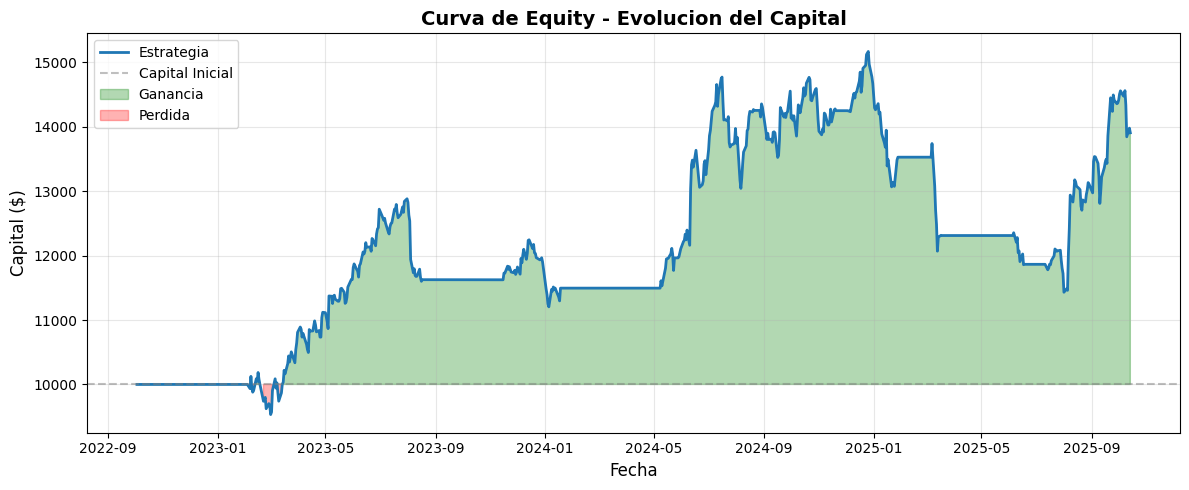

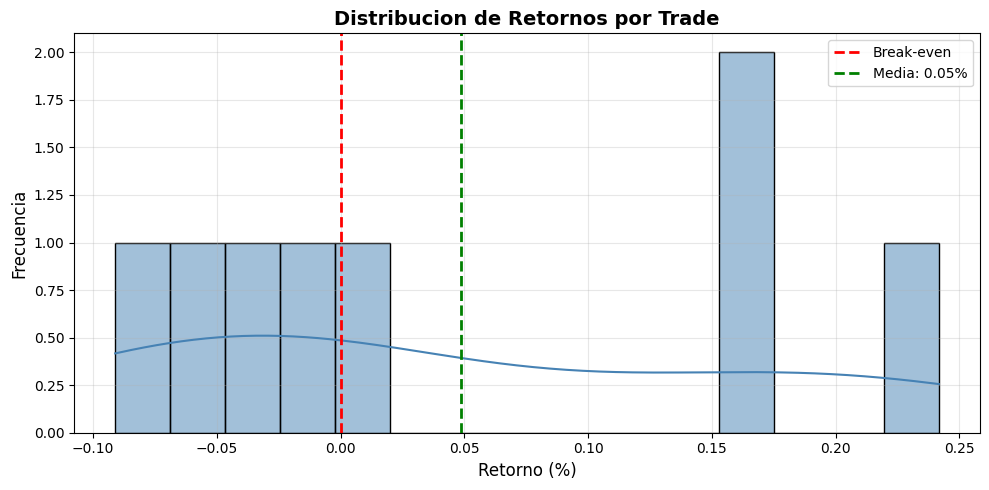


DETALLES DE LOS TRADES:
   EntryTime   ExitTime  Size  EntryPrice   ExitPrice          PnL  ReturnPct  Duration
0 2023-02-06 2023-08-17    66  150.448218  175.421767  1626.746836   0.163828       192
1 2023-11-15 2024-01-18    62  186.272950  184.527702  -131.194962  -0.011360        64
2 2024-05-09 2024-08-21    63  181.258365  225.470651  2759.750075   0.241675       104
3 2024-08-28 2024-11-20    62  226.864164  227.253279    -4.030143  -0.000287        84
4 2024-12-04 2025-01-28    58  242.010886  230.033414  -722.071989  -0.051442        55
5 2025-03-07 2025-03-18    57  234.535915  213.637081 -1216.779350  -0.091018        11
6 2025-06-06 2025-06-18    60  202.769872  195.717873  -447.029200  -0.036744        12
7 2025-07-14 2025-10-14    56  209.692012  246.615005  2042.134461   0.173906        92

ESTADISTICAS DE TRADES:
Total de trades: 8
Ganadores: 3 (37.5%)
Perdedores: 5 (62.5%)

Retorno promedio ganador: 0.19%
Retorno promedio perdedor: -0.04%
Mejor trade: 0.24%
Peor trade

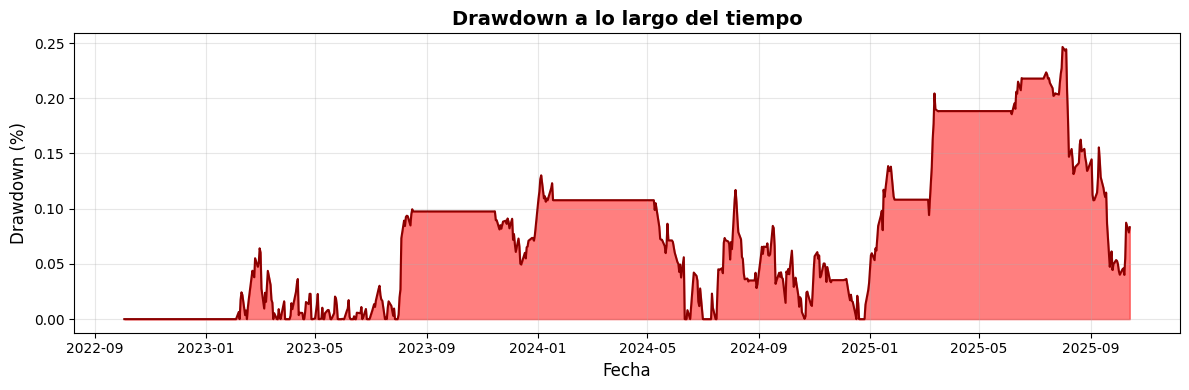

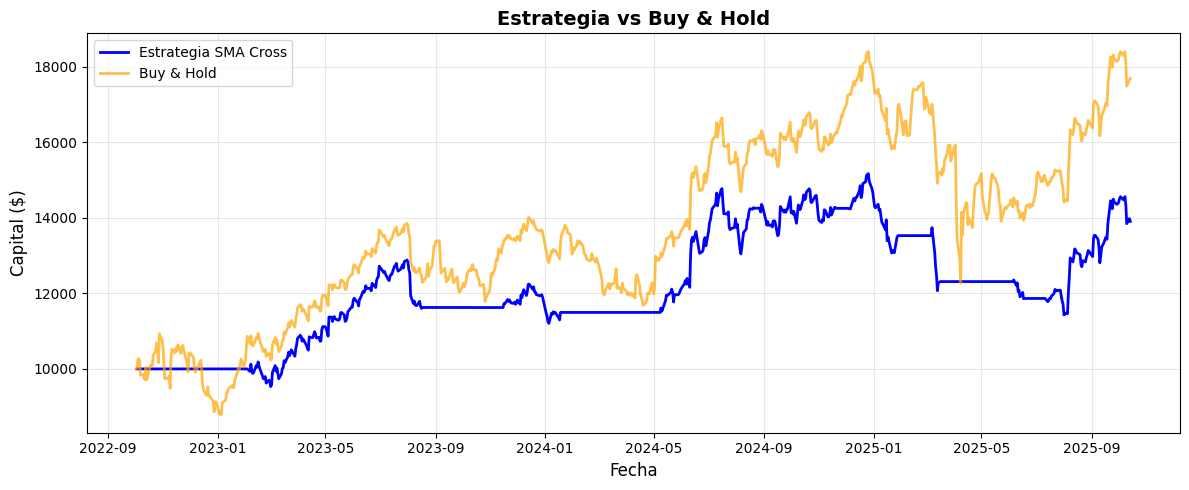


COMPARACION FINAL:
Estrategia: $13907.53 (39.08%)
Buy & Hold: $17687.30 (74.09%)


In [6]:
# Extraer la curva de equity de los resultados
equity = stats['_equity_curve']['Equity']
trades_df = stats['_trades']

# 1. Curva de Equity
plt.figure(figsize=(12, 5))
plt.plot(equity.index, equity.values, linewidth=2, label='Estrategia')
plt.axhline(y=10000, color='gray', linestyle='--', alpha=0.5, label='Capital Inicial')
plt.fill_between(equity.index, 10000, equity.values,
                 where=(equity.values >= 10000), alpha=0.3, color='green', label='Ganancia')
plt.fill_between(equity.index, 10000, equity.values,
                 where=(equity.values < 10000), alpha=0.3, color='red', label='Perdida')
plt.title("Curva de Equity - Evolucion del Capital", fontsize=14, fontweight='bold')
plt.ylabel("Capital ($)", fontsize=12)
plt.xlabel("Fecha", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Histograma de Retornos por Trade
if len(trades_df) > 0:
    trade_returns = trades_df['ReturnPct']

    plt.figure(figsize=(10, 5))
    sns.histplot(trade_returns, kde=True, bins=15, color='steelblue')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
    plt.axvline(x=trade_returns.mean(), color='green', linestyle='--',
                linewidth=2, label=f'Media: {trade_returns.mean():.2f}%')
    plt.title("Distribucion de Retornos por Trade", fontsize=14, fontweight='bold')
    plt.xlabel("Retorno (%)", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Tabla de Trades (corregir warning)
    print("\nDETALLES DE LOS TRADES:")
    print("="*80)
    trades_display = trades_df[['EntryTime', 'ExitTime', 'Size',
                                  'EntryPrice', 'ExitPrice', 'PnL', 'ReturnPct']].copy()
    trades_display['Duration'] = (pd.to_datetime(trades_display['ExitTime']) -
                                   pd.to_datetime(trades_display['EntryTime'])).dt.days
    print(trades_display.to_string())

    # 4. Estadisticas por Trade
    print("\nESTADISTICAS DE TRADES:")
    print("="*80)
    winners = trades_df[trades_df['ReturnPct'] > 0]
    losers = trades_df[trades_df['ReturnPct'] < 0]

    print(f"Total de trades: {len(trades_df)}")
    print(f"Ganadores: {len(winners)} ({len(winners)/len(trades_df)*100:.1f}%)")
    print(f"Perdedores: {len(losers)} ({len(losers)/len(trades_df)*100:.1f}%)")
    print(f"\nRetorno promedio ganador: {winners['ReturnPct'].mean():.2f}%")
    print(f"Retorno promedio perdedor: {losers['ReturnPct'].mean():.2f}%")
    print(f"Mejor trade: {trades_df['ReturnPct'].max():.2f}%")
    print(f"Peor trade: {trades_df['ReturnPct'].min():.2f}%")
    print(f"Duracion promedio: {trades_display['Duration'].mean():.0f} dias")

else:
    print("No hay trades para analizar")

# 5. Grafico de Drawdown
drawdown = stats['_equity_curve']['DrawdownPct']

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, 0, drawdown.values, alpha=0.5, color='red')
plt.plot(drawdown.index, drawdown.values, color='darkred', linewidth=1.5)
plt.title("Drawdown a lo largo del tiempo", fontsize=14, fontweight='bold')
plt.ylabel("Drawdown (%)", fontsize=12)
plt.xlabel("Fecha", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Comparacion con Buy & Hold
buy_hold_equity = (df['Close'] / df['Close'].iloc[0]) * 10000

plt.figure(figsize=(12, 5))
plt.plot(equity.index, equity.values, linewidth=2, label='Estrategia SMA Cross', color='blue')
plt.plot(buy_hold_equity.index, buy_hold_equity.values, linewidth=2,
         label='Buy & Hold', color='orange', alpha=0.7)
plt.title("Estrategia vs Buy & Hold", fontsize=14, fontweight='bold')
plt.ylabel("Capital ($)", fontsize=12)
plt.xlabel("Fecha", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCOMPARACION FINAL:")
print(f"Estrategia: ${equity.iloc[-1]:.2f} ({stats['Return [%]']:.2f}%)")
print(f"Buy & Hold: ${buy_hold_equity.iloc[-1]:.2f} ({stats['Buy & Hold Return [%]']:.2f}%)")

### 1️⃣1️⃣ Robustez y pruebas adicionales:

### Walk-forward validation: entrenar parámetros en ventana A, probar en B.

### Optimización con penalización por complejidad: evita overfitting.

### Prueba en múltiples activos/periodos: confirma generalidad.

### Incluir costos reales: comisiones, slippage, tamaños discretos.

### Stress testing: simular crisis o shocks (2008, 2020) para ver comportamiento.

### 1️⃣2️⃣ Conclusión.

### Resumen corto: El backtesting es la herramienta que te permite transformar una idea en evidencia cuantitativa. Con backtesting.py puedes pasar de una regla simple (SMA cross) a métricas robustas (Sharpe, MDD, equity curve) y tomar decisiones mejor informadas. Siempre complementa con validación fuera de muestra, costos reales y juicio humano.

### Extensiones prácticas:

### Implementa walk-forward y cross-validation.

### Añade restricciones (tamaño máximo por operación) y pruebas con portafolios multi-activo.

### Automatiza reportes periódicos y alertas.

Descargo de responsabilidad:

Esta publicacion es puramente informativa y no constituye asesoramiento financiero de ningun tipo. No se recomienda tomar decisiones de inversión basadas únicamente en esta información. Se aconseja realizar un análisis propio y consultar a un profesional financiero antes de tomar decisiones de inversión. Las decisiones de inversión son responsabilidad exclusiva del lector.

En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.

● No es una asesoría financiera.

● No supone en ningún caso, esto sea recomendación de inversión, de compra o de venta de ningún activo/bien o subyacente.

● El contenido del articulo es meramente informativo.

● En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.